# A/B Testing: New page vs Old page

A homepage is providing cat adoption. They want to see if changing the page layout would yield higher conversion rate, that is more cat adoption. 


Before comparing the two pages, we want to know what the conversion rate looks like initiatlly, that is the baseline conversion. A power analysis will be performed just to show the concept in python. A/B testing will be performed in the end to see if there is any difference between the conversion rate for the new and old page.     

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

df = pd.read_csv('click_data.csv')

In [2]:
# Check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   visit_date           3650 non-null   object
 1   clicked_adopt_today  3650 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB


In [3]:
# Descriptive data
df.describe()

,clicked_adopt_today
count,3650.000000
mean,0.277260
std,0.447707
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [4]:
# Get a view how the data frame looks like
df.head()

,visit_date,clicked_adopt_today
0,2017-01-01,1
1,2017-01-02,1
2,2017-01-03,0
3,2017-01-04,1
4,2017-01-05,1


In [5]:
print('The time period is {} to {}'.format(df['visit_date'].min(),df['visit_date'].max()))

The time period is 2017-01-01 to 2017-12-31


Calculate the conversion rate over the whole time period

In [6]:
# Converion on the whole period
conversion = df[df['clicked_adopt_today'] == 1].count()/df['clicked_adopt_today'].count()
conversion['clicked_adopt_today']

0.2772602739726027

Overall the conversion rate is 27.8% over entire year. Let's also look if there is any seasonality on the conversion rate.

In [7]:
# Conversion for each month

df['visit_date'] = pd.to_datetime(df['visit_date'])
conv_month = df.groupby(pd.Grouper(key='visit_date', freq='M')).mean()
conv_month


,clicked_adopt_today
visit_date,
2017-01-31,0.196774
2017-02-28,0.189286
2017-03-31,0.145161
2017-04-30,0.150000
2017-05-31,0.258065
2017-06-30,0.333333
2017-07-31,0.348387
2017-08-31,0.541935
2017-09-30,0.293333


The conversion rate seems to be not consistens. It appears to be some seasonality between the months. We will plot the conversion rate to get a better picture of the conversion.

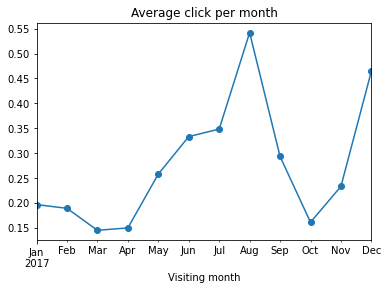

In [8]:
# Visualise the average click per month 
import matplotlib.pyplot as plt
conv_month.plot(title='Average click per month', xlabel='Visiting month', style='o-',legend =False)
plt.show()


Conversion rate are higher during August and December while Mars and April have a lower conversion.

## Power analysis for experimental design and how different parameter influence power
Power analysis is a method to determine how big the sample size is required in order to make a good judgement. In other word, to correctly reject the null hypothesis. To do that we need Power and Power is the probability that we can correctly reject the null hypothesis, which is usually 0.8 or higher.

Below is a plot that shows the relationship between power, confidence level and sample size.

In [9]:
# The necessary function for determine the sample size

def get_power(n, p1, p2, cl):
    """
    Calculate the power
    
    INPUT: n = sample size
           p1 = control group mean
           p2 = test group mean
           cl = confidence level
    OUTPUT: Power
    """
    
    
    alpha = 1 - cl                   
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)

def get_sample_size(power, p1, p2, cl, max_n=1000000):
    """
    Calculate the sample size based on the input data. 
    Initial sample size is 1 and increases by 1 for every iteration until max sample size 1000000 is reached.
    However, if the the calculated power from get_power is equal or bigger than input power then the iteration stops and 
    the function return the sample size.
    If the sample size exceed 1000 000 the function will return a warning message.
    
    INPUT: power = The power for the sample size
           p1 = control group mean
           p2 = test group mean
           cl = confidence level
           max_n = Maximum sample size allowed
    OUTPUT: The required sample size for the given inputs or a text message
    """
    n = 1 
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)
        if tmp_power >= power: 
            return "The sample size should be {} for the control and test group respectively".format(n) 
        else: 
            n = n + 1
    return 'The maximum sample size 1000000 exceeded'


def get_power_plot(power, p1, p2, cl, max_n=1000000):
    """
    Calculate the sample size based on the input data. 
    Initial sample size is 1 and increases by 1 for every iteration until max sample size 1000000 is reached. 
    Two empty lists are created to store the sample size and power for each iteration.
    Once the calculated power from get_power is equal or bigger than input power then the iteration stops and 
    the function returns a list of sample size and power.
    If the sample size exceed 1000 000 the function will return a warning message.
    
    INPUT: power = The power for the sample size
           p1 = control group mean
           p2 = test group mean
           cl = confidence level
           max_n = Maximum sample size allowed
    OUTPUT: Return a list of sample size and power or a text message
    """
    n = 1 
    n_list =[]
    power_list = []
    while n <= max_n:
        tmp_power = get_power(n, p1, p2, cl)
        if tmp_power >= power: 
           
            return n_list,power_list
        else: 
            n = n + 1
            n_list.append(n)
            power_list.append(tmp_power)    
            
    return 'The maximum sample size 1000000 exceeded'

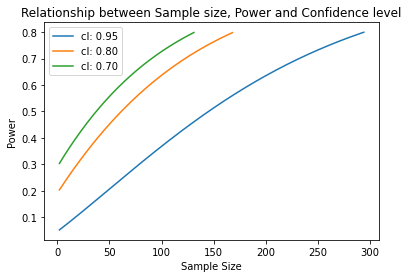

In [10]:
# Plot and see the relationship between power, confidence level and sample size

power = 0.8
conversion_rate_p1 = 0.2 # Control group
conversion_rate_p2 = 0.3 # Test group

n,p = get_power_plot(power, conversion_rate_p1, conversion_rate_p2,0.95)
df = pd.DataFrame([n,p],index=["sample_size",'power']).transpose()

plt.plot(df['sample_size'],df['power'])

n,p = get_power_plot(power, conversion_rate_p1, conversion_rate_p2,0.80)
df = pd.DataFrame([n,p],index=["sample_size",'power']).transpose()
plt.plot(df['sample_size'],df['power'])

n,p = get_power_plot(power, conversion_rate_p1, conversion_rate_p2,0.70)
df = pd.DataFrame([n,p],index=["sample_size",'power']).transpose()
plt.plot(df['sample_size'],df['power'])

plt.xlabel("Sample Size")
plt.ylabel("Power")
plt.title('Relationship between Sample size, Power and Confidence level')
plt.legend(["cl: 0.95","cl: 0.80","cl: 0.70"])

plt.show()

From the plot we can see:
*   With a fixed power, the sample size decreases with a lower confidence level
*   With a fixed confidence level, a bigger sample size gives a higher power. This means that with a higher power requires a bigger sample size!

 ### Perform Power analysis to determine sample size for our case

Assuming we want to run the test in January. 
From the previous plot <B>Average click per month</B> we saw the conversion rate is around and 20% and we want to increase the conversion to 30%

In [11]:
# Determine the sample size for our test
conversion_rate = 0.2
power = 0.8
cl = 0.95
percent_lift = 0.1
conversion_rate_p2 = 0.3
msg = get_sample_size(power, conversion_rate, conversion_rate_p2, cl)
print(msg)

The sample size should be 294 for the control and test group respectively


 # A/B testing
 ## Evaluation of control group and test group

In [12]:
# Read the experiment run in Januari and calculate the conversion for respetively group

df = pd.read_csv('experiment_data.csv')

conversion_con_tes = df.groupby('condition').mean()
conversion_con_tes.rename(columns={'clicked_adopt_today':'Conversion'})

,Conversion
condition,
control,0.166667
test,0.384354


Overall the conversion looks higher for the test group. Lets plot to see how the conversion is in more detail during Januari

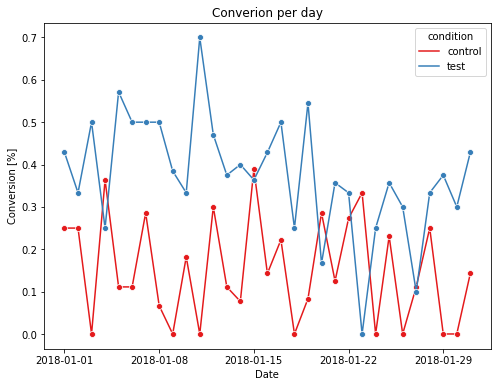

In [13]:
converion_date = df.groupby(['visit_date','condition']).mean()
converion_date.reset_index(inplace=True)

plt.figure(figsize=(8,6))
sns.lineplot(data=converion_date, 
             x=converion_date['visit_date'], 
             y=converion_date['clicked_adopt_today'], 
             hue='condition',
             marker='o',
             palette='Set1')
plt.xticks(np.arange(0,31,7))
plt.title('Converion per day')
plt.xlabel('Date')
plt.ylabel('Conversion [%]')
plt.show()

The conversion looks indeed higher for the test group when looking daily-resolution.
To confirm that we will use A/B testing. The output variable (dependent variable) is binary (categorical) so we will use a generalized linear model which can enable logistic regression with parameter `family=sm.families.Binomial()`. 

With a significance level of  5%, we define our hypothesis:
$$
H_{0}: \text{No diffrence between Control group and Test group}
$$
$$
H_{A}: \text{There is a difference between Control group and Test group}
$$

In [14]:
converion_date['condition']=converion_date['condition'].map({'control':'0','test':'1'})

binomial_model = sm.formula.glm("clicked_adopt_today~condition",
                                data=df, 
                                family=sm.families.Binomial())
result = binomial_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                  
===============================================================================
Dep. Variable:     clicked_adopt_today   No. Observations:                  588
Model:                             GLM   Df Residuals:                      586
Model Family:                 Binomial   Df Model:                            1
Link Function:                   logit   Scale:                          1.0000
Method:                           IRLS   Log-Likelihood:                -328.31
Date:                 Mon, 23 Nov 2020   Deviance:                       656.63
Time:                         10:19:56   Pearson chi2:                     588.
No. Iterations:                      4                                         
Covariance Type:             nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.6094      0.156    -10.284      0.000      -1.916      -1.303
condition[T.test]     1.1383      0.197      5.774      0.000       0.752       1.525
=====================================================================================
"""

From <I>Generalized Linear Model Regression Results</I> we can see that the confidence interval for Test group does not contain 0 and the the p-value is way below 0.05. We can reject the null hypothesis and accept alternative hypothesis that the groups are  statistical significant different.

# Conclusion 

We have determined the base value for our A/B-testing and also showed how Power Analysis influence the sample size. Power analysis were used to determine the sample sizes control group and test group respectively for A/B-testing. The A/B test showed that the test group with the new page have a higher conversion rate.